In [175]:
from hmmlearn import hmm

In [176]:
# I create two cities, each has two states: it shines and it rains and two observations: tom ate ice cream, tom did not eat ice cream 

sunny_city = hmm.CategoricalHMM(n_components=2, n_features=2)  
rainy_city = hmm.CategoricalHMM(n_components=2, n_features=2)

sunny_city.transmat_ = [
    [0.9, 0.1],  # If it shines, there is 0.9 probability that it will continue shining
    [0.8, 0.2]   # If it rains, there is 0.8 probability that it will stop raining and start shining
]

rainy_city.transmat_ = [
    [0.3, 0.7],  # If it shines, there is 0.7 probability that it will stop shining and start raining
    [0.2, 0.8]   # If it rains, there is 0.8 probability that it will continue raining
]

# Tom likes to eat ice cream when it shines.
sunny_city.emissionprob_ = rainy_city.emissionprob_ = [
    [0.1, 0.9],
    [0.9, 0.1],
]

# Each city will start with a lovely weather
sunny_city.startprob_ = rainy_city.startprob_ = [1.0, 0.0]

In [177]:
ice_cream_eaten, _ = sunny_city.sample(n_samples=200)
ice_cream_eaten.sum()

167

In [178]:
ice_cream_eaten, _ = rainy_city.sample(n_samples=200)
ice_cream_eaten.sum()

61

In [179]:
weeks_train = {
    'sunny': [sunny_city.sample(n_samples=7)[0] for _ in range(200)],
    'rainy': [rainy_city.sample(n_samples=7)[0] for _ in range(200)]
}

weeks_test = {
    'sunny': [sunny_city.sample(n_samples=7)[0] for _ in range(20)],
    'rainy': [rainy_city.sample(n_samples=7)[0] for _ in range(20)]
}

In [180]:
import torchhd as hd
from functools import reduce
d = 10_000


observations = hd.random(2, d)

In [181]:
def encode_sequence(sequence_of_observations):
    sequence = reduce(lambda sequence, new_observation: hd.bundle(hd.permute(sequence), observations[new_observation]), sequence_of_observations)
    return sequence        

sunny_sequences_encoded = [encode_sequence(sequence) for sequence in weeks_train['sunny']]
sunny_sequence_model = reduce(lambda sequence_1, sequence_2: hd.bundle(sequence_1, sequence_2), sunny_sequences_encoded)

rainy_sequences_encoded = [encode_sequence(sequence) for sequence in weeks_train['rainy']]
rainy_sequence_model = reduce(lambda sequence_1, sequence_2: hd.bundle(sequence_1, sequence_2), rainy_sequences_encoded)

In [182]:
true_label = []
predicted_label = []

for label, sequences in weeks_train.items():
    sequences_encoded = [encode_sequence(sequence) for sequence in sequences]
    
    for sequence_encoded in sequences_encoded:
        if hd.cosine_similarity(sequence_encoded, sunny_sequence_model) > hd.cosine_similarity(sequence_encoded, rainy_sequence_model):
            predicted_label.append('sunny')
        else:
            predicted_label.append('rainy')
            
        true_label.append(label)

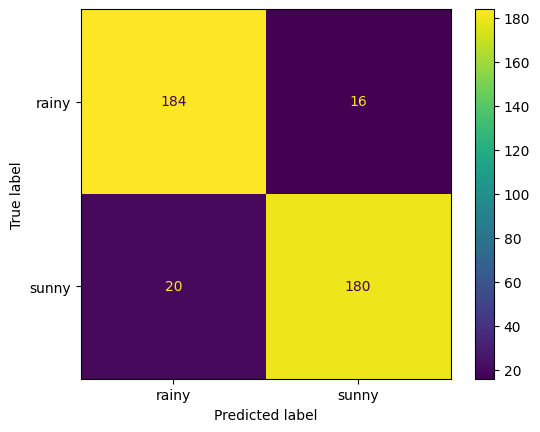

In [183]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(true_label, predicted_label)